In [ ]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
from sklearn.metrics import RocCurveDisplay
import sklearn.feature_selection
import sklearn.pipeline
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, auc, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

# Hier werden unterschiedliche optimale XGBoost Modelle erstellt.
# GridSearchCV wird für die Suche nach optimalen Parametern angewendet
# Training und Evaluation passiert auf der 5-Kreuzvalidierung
# und das alles passiert auf drei Datensätzen

In [ ]:
df = pd.read_csv('./../data/german_onehotencoded.csv')
ds = df.to_numpy()
y = ds[:,-2: -1] # for last column
x = ds[:, :-2] # for all but last column

cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
precisionrecalllist = []
y_pred_scores_list = []
mean_fpr = np.linspace(0, 1, 100)

y_real = []
y_proba = []
axes_steps = []

# play with these params
params={
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
}

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(x, y)):
    
    xgb_clf = xgb.XGBClassifier(seed=42)

    grid_search_cv = GridSearchCV(xgb_clf,
                  params,
                  cv=2,
                  scoring="roc_auc",
                  n_jobs=1,
                  verbose=False)
    
    grid_search_cv.fit(x[train], y[train], eval_metric='mlogloss')

    model = grid_search_cv.best_estimator_

    pred = model.predict(x[test])

    pred_proba = model.predict_proba(x[test])
    pred_scores = pred_proba.max(axis=1)
    print('F1: ', f1_score(pred, y[test]))
    print('Precision: ', precision_score(pred, y[test]))
    print('Recall: ', recall_score(pred, y[test]))
    tn, fp, fn, tp = confusion_matrix(y[test], pred).ravel()
    false_positive_rate = fp / (fp + tn)
    true_positive_rate = tp / (tp + fp)
    print('false positive rate: ', false_positive_rate)
    print('true positive rate:', true_positive_rate)

    precision, recall, _ = precision_recall_curve(y[test], pred_proba[:,1])

    y_real.append(y[test])
    y_proba.append(pred_proba[:,1])
    y_pred_scores_list.append(pred_scores)

    lab = 'Fold %d' % (i+1)
    axes_steps.append((recall, precision, lab))

    viz = RocCurveDisplay.from_estimator(
        model,
        x[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    prec, recall, _ = precision_recall_curve(pred, pred_scores, pos_label=np.array([x[0] for x in y[test].tolist()]))
    precisionrecalllist.append([prec, recall])

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
)
ax.legend(loc="lower right")
plt.savefig('xg_german_onehotencoded_roc.pdf')
plt.show()

#print(precisionrecalllist)

(5, 200)
(5, 200, 1)
(5, 200)


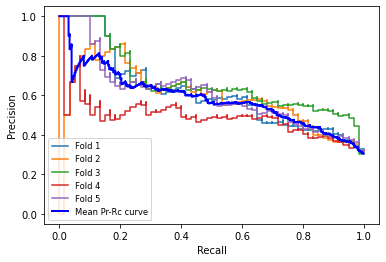

In [15]:
print(np.array(y_proba).shape)
print(np.array(y_real).shape)
print(np.array(y_pred_scores_list).shape)

fig, ax = plt.subplots()

for i in range(len(axes_steps)):
    ax.step(axes_steps[i][0], axes_steps[i][1], label = axes_steps[i][2])

y_real_test = np.concatenate(np.array(y_real))
y_proba_test = np.concatenate(np.array(y_proba))

precision, recall, _ = precision_recall_curve(y_real_test, y_proba_test)
lab = 'Mean Pr-Rc curve'
ax.step(recall, precision, label=lab, lw=2, color='b')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='lower left', fontsize='small')
plt.savefig('xg_german_onehotencoded_prre.pdf')

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
)

plt.show()

F1:  0.182720953326713
Precision:  0.9292929292929293
Recall:  0.1013215859030837
false positive rate:  0.014350280498742592
true positive rate: 0.1013215859030837
F1:  0.8681318681318682
Precision:  0.797979797979798
Recall:  0.9518072289156626
false positive rate:  7.03445122487382e-05
true positive rate: 0.9518072289156626
F1:  0.7272727272727272
Precision:  0.6530612244897959
Recall:  0.8205128205128205
false positive rate:  0.0002462057928705837
true positive rate: 0.8205128205128205
F1:  0.8571428571428571
Precision:  0.7653061224489796
Recall:  0.974025974025974
false positive rate:  3.51722561243691e-05
true positive rate: 0.974025974025974
F1:  0.7701863354037266
Precision:  0.6326530612244898
Recall:  0.9841269841269841
false positive rate:  1.758612806218455e-05
true positive rate: 0.9841269841269841


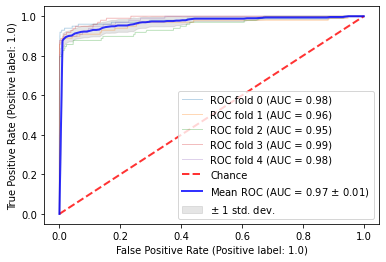

In [17]:
df = pd.read_csv('./../data/creditcard.csv')
ds = df.to_numpy()
y = ds[:, -1] # for last column
x = ds[:, :-1] # for all but last column

cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
precisionrecalllist = []
y_pred_scores_list = []
mean_fpr = np.linspace(0, 1, 100)

y_real = []
y_proba = []
axes_steps = []

# play with these params
params={
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
}

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(x, y)):

    xgb_clf = xgb.XGBClassifier(seed=42)

    grid_search_cv = GridSearchCV(xgb_clf,
                  params,
                  cv=2,
                  scoring="roc_auc",
                  n_jobs=1,
                  verbose=False)
    
    grid_search_cv.fit(x[train], y[train], eval_metric='mlogloss')

    model = grid_search_cv.best_estimator_

    pred = model.predict(x[test])

    pred_proba = model.predict_proba(x[test])
    pred_scores = pred_proba.max(axis=1)
    print('F1: ', f1_score(pred, y[test]))
    print('Precision: ', precision_score(pred, y[test]))
    print('Recall: ', recall_score(pred, y[test]))
    tn, fp, fn, tp = confusion_matrix(y[test], pred).ravel()
    false_positive_rate = fp / (fp + tn)
    true_positive_rate = tp / (tp + fp)
    print('false positive rate: ', false_positive_rate)
    print('true positive rate:', true_positive_rate)

    precision, recall, _ = precision_recall_curve(y[test], pred_proba[:,1])

    y_real.append(y[test])
    y_proba.append(pred_proba[:,1])
    y_pred_scores_list.append(pred_scores)

    lab = 'Fold %d' % (i+1)
    axes_steps.append((recall, precision, lab))

    viz = RocCurveDisplay.from_estimator(
        model,
        x[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    prec, recall, _ = precision_recall_curve(pred, pred_scores, pos_label=y[test])
    precisionrecalllist.append([prec, recall])

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
)
ax.legend(loc="lower right")
plt.savefig('xg_creditcard_roc.pdf')
plt.show()


(5,)
(5,)
(5,)


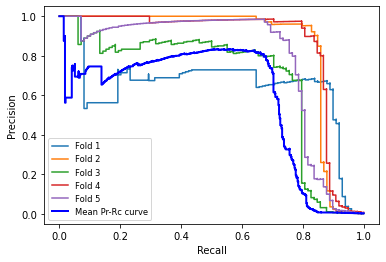

In [18]:
print(np.array(y_proba).shape)
print(np.array(y_real).shape)
print(np.array(y_pred_scores_list).shape)

fig, ax = plt.subplots()

for i in range(len(axes_steps)):
    ax.step(axes_steps[i][0], axes_steps[i][1], label = axes_steps[i][2])

y_real_test = np.concatenate(np.array(y_real))
y_proba_test = np.concatenate(np.array(y_proba))

precision, recall, _ = precision_recall_curve(y_real_test, y_proba_test)
lab = 'Mean Pr-Rc curve'
ax.step(recall, precision, label=lab, lw=2, color='b')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='lower left', fontsize='small')
plt.savefig('xg_creditcard_prre.pdf')

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
)

plt.show()

In [37]:
df = pd.read_csv('./../data/application_data_onehotencoded.csv')
df = df.fillna(0)
y = df['TARGET'].to_numpy().reshape(-1,1) # for last column

a = [df.columns[0]]
b = df.columns[2:]
res = [*a, *b]
x = df[res].to_numpy() # for all but last column

print(x.shape)
print(y.shape)

number_of_1 = np.where(y==1)[0]
number_of_0 = np.where(y==0)[0][:number_of_1.shape[0]]

print(number_of_1.shape, number_of_0.shape)
print(number_of_1)
print(number_of_0)

(307511, 251)
(307511, 1)
(24825,) (24825,)
[     0     26     40 ... 307481 307489 307509]
[    1     2     3 ... 26976 26977 26978]


In [38]:
x1=x[number_of_1]
x0=x[number_of_0]

y1=y[number_of_1]
y0=y[number_of_0]

x = np.concatenate((x1,x0))
y = np.concatenate((y1,y0))

print(x.shape)
print(y.shape)

(49650, 251)
(49650, 1)


F1:  0.4330124664667824
Precision:  0.27633434038267873
Recall:  1.0
false positive rate:  0.0
true positive rate: 1.0
F1:  0.7155209684392564
Precision:  1.0
Recall:  0.5570514978121844
false positive rate:  0.795166163141994
true positive rate: 0.5570514978121844
F1:  0.6830375567478333
Precision:  1.0
Recall:  0.5186461924161705
false positive rate:  0.9280966767371601
true positive rate: 0.5186461924161705
F1:  0.6816309719934102
Precision:  1.0
Recall:  0.5170259293970634
false positive rate:  0.9341389728096676
true positive rate: 0.5170259293970634
F1:  0.6670697299476018
Precision:  1.0
Recall:  0.5004535833081343
false positive rate:  0.9981873111782478
true positive rate: 0.5004535833081343


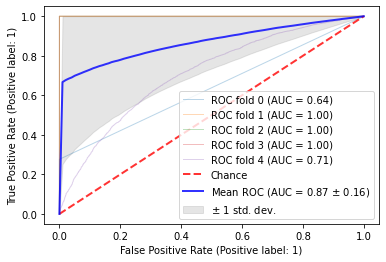

In [40]:
cv = StratifiedKFold(n_splits=5)

tprs = []
aucs = []
precisionrecalllist = []
y_pred_scores_list = []
mean_fpr = np.linspace(0, 1, 100)

y_real = []
y_proba = []
axes_steps = []

# play with these params
params={
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
}

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(x, y)):

    xgb_clf = xgb.XGBClassifier(seed=42)

    grid_search_cv = GridSearchCV(xgb_clf,
                  params,
                  scoring="roc_auc",
                  n_jobs=6,
                  verbose=False)

    grid_search_cv.fit(x[train], y[train], eval_metric='mlogloss')

    model = grid_search_cv.best_estimator_

    pred = model.predict(x[test])

    pred_proba = model.predict_proba(x[test])
    pred_scores = pred_proba.max(axis=1)
    print('F1: ', f1_score(pred, y[test]))
    print('Precision: ', precision_score(pred, y[test]))
    print('Recall: ', recall_score(pred, y[test]))
    tn, fp, fn, tp = confusion_matrix(y[test], pred).ravel()
    false_positive_rate = fp / (fp + tn)
    true_positive_rate = tp / (tp + fp)
    print('false positive rate: ', false_positive_rate)
    print('true positive rate:', true_positive_rate)

    precision, recall, _ = precision_recall_curve(y[test], pred_proba[:,1])
    precisionrecalllist.append([precision, recall])
    
    y_real.append(y[test])
    y_proba.append(pred_proba[:,1])
    y_pred_scores_list.append(pred_scores)

    lab = 'Fold %d' % (i+1)
    axes_steps.append((recall, precision, lab))

    viz = RocCurveDisplay.from_estimator(
        model,
        x[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    #prec, recall, _ = precision_recall_curve(pred, pred_scores, pos_label=y[test])
    #precisionrecalllist.append([prec, recall])

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
)
ax.legend(loc="lower right")
plt.savefig('xg_application_data_onehotencoded_roc.pdf')
plt.show()


(5, 9930)
(5, 9930, 1)
(5, 9930)


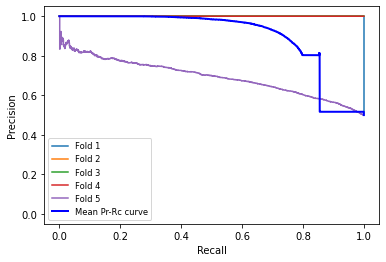

In [41]:
print(np.array(y_proba).shape)
print(np.array(y_real).shape)
print(np.array(y_pred_scores_list).shape)

fig, ax = plt.subplots()

for i in range(len(axes_steps)):
    ax.step(axes_steps[i][0], axes_steps[i][1], label= axes_steps[i][2])

y_real_test = np.concatenate(np.array(y_real))
y_proba_test = np.concatenate(np.array(y_proba))

precision, recall, _ = precision_recall_curve(y_real_test, y_proba_test)
lab = 'Mean Pr-Rc curve'
ax.step(recall, precision, label=lab, lw=2, color='b')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='lower left', fontsize='small')
plt.savefig('xg_application_data_onehotencoded_prre.pdf')

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
)

plt.show()